<a href="https://colab.research.google.com/github/ydblank/ModelSelectionExercise/blob/main/Model_Selection_and_Hypertuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Selection and Hypertuning





## Load the necessary packages

In [50]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint #Continuous values for randomized
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #Hypertuning
from sklearn.model_selection import cross_val_score #For cross-validation
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor

## Load the data

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/flyandlure/datasets/master/housing.csv')
df.head().T


,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


## Feature Engineering

In [25]:
df['ocean_proximity'] = df['ocean_proximity'].str.lower().replace('[^0-9a-zA-Z]+','_',regex=True) #lowercase and non-alpha -> _
encodings = pd.get_dummies(df['ocean_proximity'], prefix='proximity') #one hot encoding for ocean_proximity
df = pd.concat([df, encodings], axis=1)

In [26]:
income_labels = ['5','4','3', '2', '1']
df['income_bin'] = pd.cut(df['median_income'], bins=5, labels=income_labels).astype(int) #binning of median income for simplifying

## Remove outliers

In [27]:
df = df.loc[df['median_house_value']<500000,:] #filter


## Remove collinear features

In [28]:
df = df.drop(["households","total_bedrooms","population"],axis=1) #further simplification and highlight unique features

## Handle missing values

In [38]:
df = df.fillna(0) #fill missing values
fraction = 0.1
df_sampled = df.sample(frac=fraction, random_state=1) #fraction and random sampling

num_rows_sampled = df_sampled.shape[0]
print("Number of rows in the sampled fraction:", num_rows_sampled)

Number of rows in the sampled fraction: 1965


## Create training and test datasets

In [39]:
X = df_sampled.drop(['median_house_value','ocean_proximity'], axis=1) #removed features for input x
y = df_sampled['median_house_value'] #set feature for target y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #data split 70:30, reproducability

## Scale the data

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #sets mean to 0 and standard deviation to 1
X_test = scaler.transform(X_test) #to not apply to test



## Apply model selection

In [41]:
regressors = {
    "XGBRegressor": XGBRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "LinearSVR": LinearSVR(),
    "KernelRidge": KernelRidge(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
}

In [42]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse', 'rmse_cv']) #root mean squared error

for key in regressors: #dictionary of models

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train) #training
    y_pred = model.predict(X_test) #testing

    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             scoring="neg_mean_squared_error",
                             cv=10) #iterations of cross validation

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'rmse_cv': round(np.mean(np.sqrt(-scores)))
    }#metrics

    df_models = df_models.append(row, ignore_index=True)

* XGBRegressor


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* RandomForestRegressor


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* DecisionTreeRegressor
* GaussianProcessRegressor


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* SVR


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* NuSVR


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* LinearSVR
* KernelRidge


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* LinearRegression
* Ridge
* Lars
* TheilSenRegressor


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* HuberRegressor


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


* PassiveAggressiveRegressor


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stocha

* ARDRegression


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* BayesianRidge
* ElasticNet
* OrthogonalMatchingPursuit


<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
<ipython-input-42-5dd2455911ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


In [46]:
df_models.head(20).sort_values(by='rmse_cv', ascending=True) #sort and show performance of each model

,model,run_time,rmse,rmse_cv
0,XGBRegressor,0.07,53177,54878
1,RandomForestRegressor,0.11,51989,55116
8,LinearRegression,0.0,63914,64172
9,Ridge,0.0,63930,64186
10,Lars,0.0,63914,64189
15,BayesianRidge,0.0,64000,64196
14,ARDRegression,0.01,65195,64725
12,HuberRegressor,0.0,65753,64759
13,PassiveAggressiveRegressor,0.02,66950,65650
16,ElasticNet,0.0,67873,67046


## Assess the top performing model

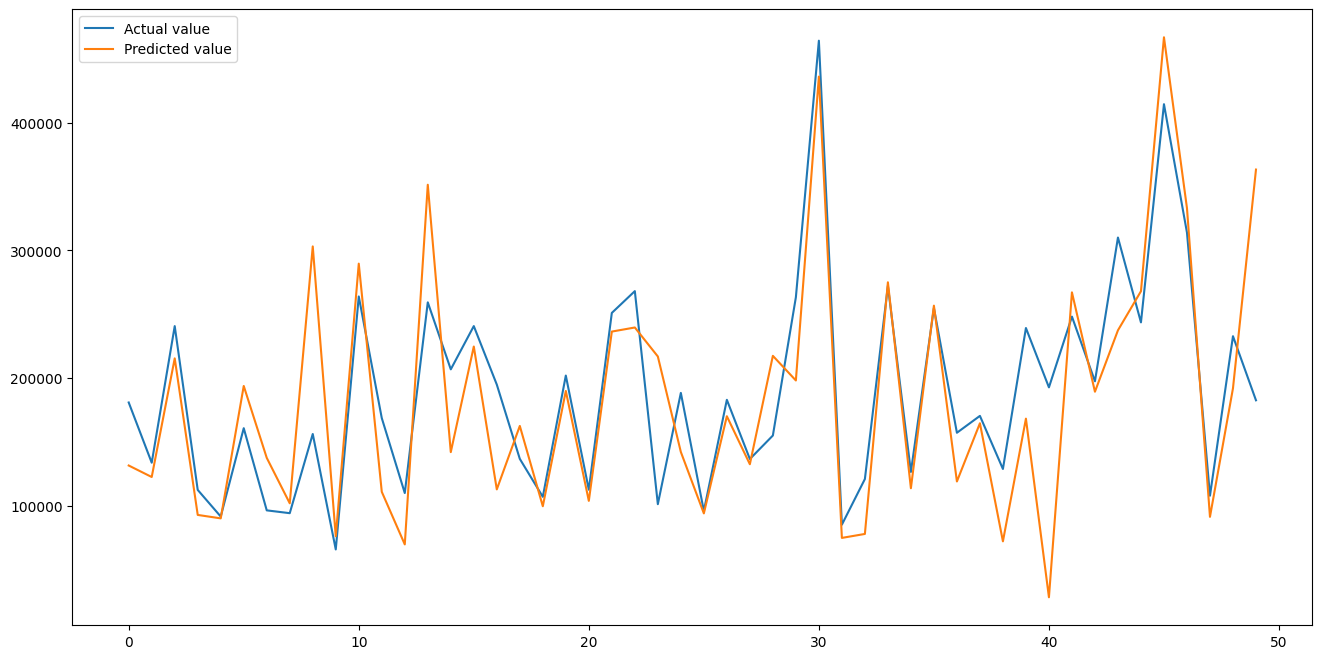

In [43]:
regressor = XGBRegressor()
model = regressor.fit(X_train, y_train) #training
y_pred = model.predict(X_test) #testing
test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig= plt.figure(figsize=(16,8)) #plotting
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])

## Tune the model’s hyperparameters

In [44]:
model.get_params()
{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': np.nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [47]:
param_grid = dict(  #grid-search parameters
    n_jobs=[16],
    learning_rate=[0.1, 0.5],
    objective=['reg:squarederror'],
    gamma=[0.05, 0.5],
    scale_pos_weight=[0, 1],
    reg_alpha=[0, 0.5],
    reg_lambda=[1, 0],
)

model = XGBRegressor(random_state=1, verbosity=1)

grid_search = GridSearchCV(estimator=model, #gridsearch func
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', #minimize RMSE
                           )

best_model = grid_search.fit(X_train, y_train) #store best parameters
print('Optimum parameters', best_model.best_params_)

Optimum parameters {'gamma': 0.05, 'learning_rate': 0.1, 'n_jobs': 16, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 1, 'scale_pos_weight': 0}


## Fit the best model

In [48]:
regressor = XGBRegressor( #best parameters
    gamma=0,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=1000,
    n_jobs=16,
    objective='reg:squarederror',
    subsample=0.8,
    scale_pos_weight=0,
    reg_alpha=0,
    reg_lambda=1
)
model = regressor.fit(X_train, y_train) #train
y_pred = model.predict(X_test) #test

np.sqrt(mean_squared_error(y_test, y_pred)) #show rmse

52009.41520032223

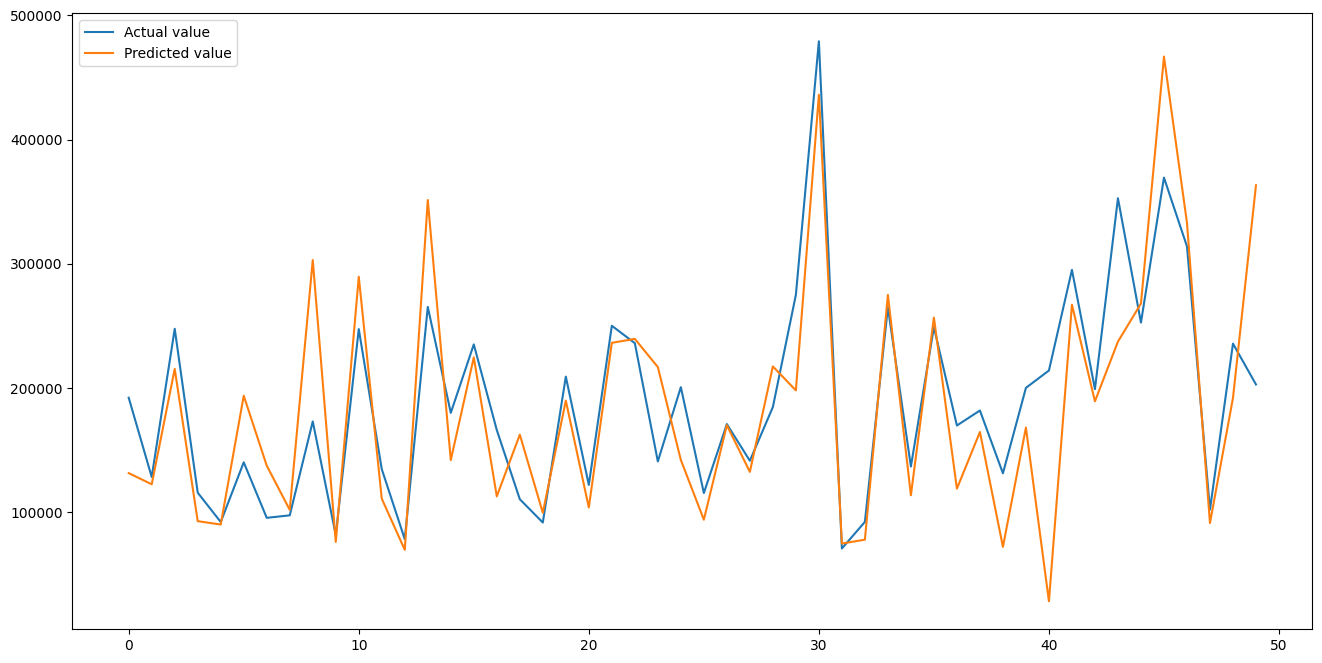

In [49]:
test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value']) #plot

In [53]:
param_dist = {
    'n_jobs': [16],
    'learning_rate': [0.1, 0.5],
    'objective': ['reg:squarederror'],
    'gamma': uniform(0.05, 0.45),  # Random values between 0.05 and 0.5
    'scale_pos_weight': [0, 1],
    'reg_alpha': uniform(0, 0.5),  # Random values between 0 and 0.5
    'reg_lambda': [1, 0],
}
n_iter_search = 20 #iteration
model = XGBRegressor(random_state=1, verbosity=1)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,  # Set to the desired number of parallel jobs
    random_state=42,
    cv=5  # cross-validation iteration
)
best_model = random_search.fit(X_train, y_train) #store best parameters
print('Optimum parameters:', best_model.best_params_)
final_model = best_model.best_estimator_.fit(X_train, y_train) #train
y_pred = final_model.predict(X_test) #test
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE:', rmse_test)

Optimum parameters: {'gamma': 0.3165865559879191, 'learning_rate': 0.1, 'n_jobs': 16, 'objective': 'reg:squarederror', 'reg_alpha': 0.4299702033681603, 'reg_lambda': 1, 'scale_pos_weight': 0}
Test RMSE: 51386.25297659284


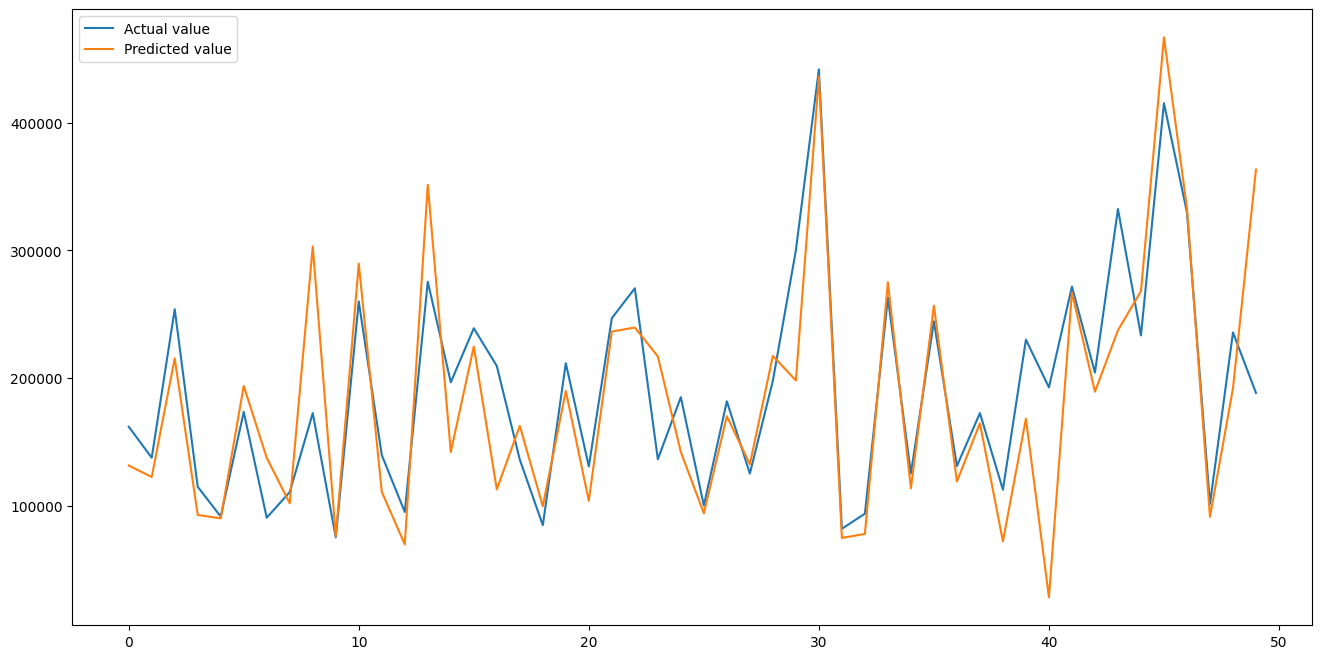

In [54]:
test = pd.DataFrame({'Predicted value': y_pred, 'Actual value': y_test})
fig = plt.figure(figsize=(16, 8))
test = test.reset_index()
test = test.drop(['index'], axis=1)
plt.plot(test[:50])
plt.legend(['Actual value', 'Predicted value'])
plt.show()